# Estudiar coeficiente de transmisión

En esta segunda parte están las tareas correspondientes al problema voluntario del ejercicio sobre la ecuación de Schrodinger. Ahora, el objetivo es estudiar el coeficiente de transmisión, el cual definimos como la probabilidad de encontrar la partícula a un lado u otro de un obstáculo para tiempos largos.

Sabemos que para calcular la probabilidad de encontrar una partícula entre dos puntos $x_1$ y $x_2$ es

$P(x_1, x_2) = \int_{x_1}^{x_2} |\Phi(x)|^2 \,\mathrm{d}x$

Después de realizar el experimento $m$ veces el coeficiente de transmisión será $K = m_T / m$, donde $m_T$ es el número de veces que hemos detectado a la partícula a la derecha del potencial.



#### Celda 1

Al igual que antes, se definen las librerías necesarias para la ejecución del código.

In [75]:
import os
import numpy as np
import random
import time
import matplotlib.pyplot as plt
from numba import njit, prange, set_num_threads

#### Celda 2

Definimos el número de hilos a usar.

In [76]:
num_threads = input("Introduce el número de hilos a usar (deja vacío para usar todos los disponibles): ")

if num_threads.strip() == "":
    num_threads = os.cpu_count()  # Obtener el número de hilos disponibles
else:
    num_threads = int(num_threads) 

set_num_threads(num_threads)  # Establecer el número de hilos para Numba

#### Celda 3

Definimos las constantes a partir de las cuales se determinarán el resto de valores 

In [77]:
# Parámetros
N = 500
PI = np.pi
n_ciclos = 50
lam = 0.3
pasos = 2500
experimentos = 2000

#### Celda 4

Al igual que antes, generamos los valores de $\tilde s , \tilde k_0 , \tilde V_j, \phi_{j,0}$ y $\alpha$, a partir de los valores iniciales y la condiones de contorno. En este caso, no hemos podido aplicar paralelización ya que daba lugar a errores con los índices.

In [78]:
@njit(cache=True)
def generar_parametros():
    k = 2.0 * PI * n_ciclos / N
    s = 1.0 / (4 * k * k)
    x0 = N / 4
    sigma = N / 16

    V = np.zeros(N+1)
    phi = np.zeros(N+1, dtype=np.complex128)
    norma_loc = 0.0
    # Inicialización paralela con reducción
    for j in prange(N+1):
        if 2*N/5 <= j <= 3*N/5:
            V[j] = lam * k * k
        phi[j] = np.exp(1j * k * j) * np.exp(-((j - x0)**2)/(2*sigma*sigma))
        norma_loc += phi[j].real*phi[j].real + phi[j].imag*phi[j].imag

    # Fronteras y normalización secuencial
    phi[0] = 0
    phi[N] = 0
    norma_loc = np.sqrt(norma_loc)
    for j in range(N+1):
        phi[j] /= norma_loc

    gamma = np.zeros(N, dtype=np.complex128)
    alpha = np.zeros(N, dtype=np.complex128)
    alpha[N-1] = 0
    for j in range(N-1, 0, -1):
        gamma[j] = 1.0/(-2 - V[j] + 2.0j/s + alpha[j])
        alpha[j-1] = -gamma[j]

    return k, s, V, phi, gamma, alpha

#### Celda 5

Calulamos $\beta$ empleando la relación vista en los fundamentos, y con ello podemos calcular los valores de $\chi$ y $\phi_{j, n+1}$.

In [79]:
@njit(cache=True, parallel=False, fastmath=True)
def calcular_beta(s, gamma, beta, phi, alpha, xi):
    # Barrido hacia atrás
    for j in range(N-1, 0, -1):
        beta[j-1] = gamma[j] * (4.0j * phi[j] / s - beta[j])
    # Barrido hacia adelante
    for j in range(N-1):
        xi[j+1] = alpha[j]*xi[j] + beta[j]
        phi[j+1] = xi[j+1] - phi[j+1]

#### Celda 6

Calculamos la norma de $\phi$ como $\|\phi\| = \sqrt{Re(\phi)^2 + Im(\phi)^2}$

In [80]:
@njit(cache=True, parallel=True, fastmath=True)
def calcular_norma(phi):
    suma = 0.0
    # Paralelizar reducción
    for i in prange(phi.shape[0]):
        re = phi[i].real
        im = phi[i].imag
        suma += re*re + im*im
    return np.sqrt(suma)

#### Celda 7

En esta celda se calcula la probabilidad de detectar a la partícula en el lado derecho de la barrera.

In [81]:
def calcular_PD(phi: np.ndarray) -> float:
    return np.sum(np.abs(phi[4*N//5 : N+1])**2)

#### Celda 8

Obtenemos el índice del máximo local de PD

In [82]:
def calcular_maximo(PD: np.ndarray) -> int:
    return int(np.argmax(PD))

#### Celda 9

A partir de aquí, se calculan los valores esperados para distintos observables: posición, momento, energía cinética, energía potencial y energía total.

In [83]:
def calcular_x(phi: np.ndarray) -> float:
    """Posición media x = sum_j j * |phi_j|^2"""
    j_indices = np.arange(phi.shape[0])
    return np.sum(j_indices * np.abs(phi)**2)

def calcular_p(phi: np.ndarray) -> float:
    """Momento promedio p = Im(sum_j conj(phi_j)*(phi_{j+1}-phi_j))"""
    diff = phi[1:] - phi[:-1]
    return np.imag(np.vdot(phi[:-1], diff))

def calcular_T(phi: np.ndarray) -> float:
    """Energía cinética T = sum_j -conj(phi_j)*(phi_{j+2}-2phi_{j+1}+phi_j)"""
    T = 0+0j
    for j in range(phi.size-2):
        T += -np.conj(phi[j]) * (phi[j+2] - 2*phi[j+1] + phi[j])
    return T.real

def calcular_Vobs(V: np.ndarray, phi: np.ndarray) -> float:
    """Energía potencial V = sum_j V_j * |phi_j|^2"""
    return np.sum(V * np.abs(phi)**2)

def calcular_E(phi: np.ndarray, V: np.ndarray) -> float:
    """Energía total E = T + V"""
    return calcular_T(phi) + calcular_Vobs(V, phi)

#### Celda 10

Calculamos los erros los valores esperados empleando la regla del punto medio.

In [84]:
def calcular_error_x(phi: np.ndarray) -> float:
    der2 = np.zeros(N-1)
    for j in range(N-1):
        der2[j] = ((j+2)*abs(phi[j+2])**2 - 2*(j+1)*abs(phi[j+1])**2 + j*abs(phi[j])**2)
    return np.max(der2) * N/24

def calcular_error_p(phi: np.ndarray) -> float:
    der2 = np.zeros(N-2, dtype=complex)
    for j in range(N-2):
        der2[j] = (np.conj(phi[j+2])*(phi[j+3]-phi[j+2])
                   -2*np.conj(phi[j+1])*(phi[j+2]-phi[j+1])
                   + np.conj(phi[j])*(phi[j+1]-phi[j]))
    return np.max(np.abs(der2)) * N/24

def calcular_error_T(phi: np.ndarray) -> float:
    der2 = np.zeros(N-3)
    for j in range(N-3):
        term = (np.conj(phi[j+2])*(phi[j+4]-2*phi[j+3]+phi[j+2])
                -2*np.conj(phi[j+1])*(phi[j+3]-2*phi[j+2]+phi[j+1])
                + np.conj(phi[j])*(phi[j+2]-2*phi[j+1]+phi[j]))
        der2[j] = abs(term)
    return np.max(der2) * N/24

def calcular_error_V(phi: np.ndarray, V: np.ndarray) -> float:
    max_j = min(N-2, phi.size - 3, V.size - 3)  
    if max_j <= 0:
        return 0.0
    
    der2 = np.zeros(max_j)
    for j in range(max_j):
        der2[j] = (V[j+2]*abs(phi[j+2])**2 -2*V[j+1]*abs(phi[j+1])**2 + V[j]*abs(phi[j])**2)
    return np.max(der2) * N/24

def calcular_error_E(phi: np.ndarray, V: np.ndarray) -> float:
    return calcular_error_T(phi) + calcular_error_V(phi, V)

#### Celda 11

Esta sería la celda principal, donde se llama al resto de funciones para obtener los resultados, los cuales se guardaran en los archivos "datos_PD.dat" y "datos_observables.dat", además de imprimir tanto el coeficiente de transmisión, como el máximo de la probabilidad PD. Estos archivo se creará en el directorio que se esté empleando en ese momento.

In [85]:

cwd = os.getcwd()  # Directorio actual
random.seed()

# Variables para almacenar los coeficientes de transmisión de todos los experimentos
coeficientes = np.zeros(experimentos)

# Abrir archivos de salida
with open(os.path.join(cwd,'datos_PD.dat'),'w') as f_PD, \
        open(os.path.join(cwd,'datos_observables.dat'),'w') as f_obs:

    start = time.time()
    
    for m in range(experimentos):
        # Generar coeficientes iniciales para cada experimento
        k, s, V, phi, gamma, alpha = generar_parametros()
        
        # Condiciones de contorno: beta[N-1]=xi[N]=xi[0]=0
        beta = np.zeros(N, dtype=np.complex128)
        xi = np.zeros(N+1, dtype=np.complex128)
        beta[N-1] = 0+0j
        xi[0]     = 0+0j
        xi[N]     = 0+0j

        PD = np.zeros(pasos)
        
        for l in range(pasos):
            # Probabilidad de transmisión
            PD[l] = calcular_PD(phi)
            if m == 0:  # Solo guardamos datos del primer experimento
                f_PD.write(f"{l} {PD[l]:.6e} \n")

            # Observables y errores cada 10 pasos (solo para el primer experimento)
            if m == 0 and l % 10 == 0:
                x   = calcular_x(phi)
                p   = calcular_p(phi)
                T   = calcular_T(phi)
                Vobs= calcular_Vobs(V,phi)
                E   = calcular_E(phi,V)
                ex  = calcular_error_x(phi)
                ep  = calcular_error_p(phi)
                eT  = calcular_error_T(phi)
                eV  = calcular_error_V(phi,V)
                eE  = calcular_error_E(phi,V)
                f_obs.write(f"{l} {x:.6e} {ex:.6e} {p:.6e} {ep:.6e} {T:.6e} {eT:.6e} {Vobs:.6e} {eV:.6e} {E:.6e} {eE:.6e} \n")

            # Avanzar un paso
            calcular_beta(s, gamma, beta, phi, alpha, xi)

        # Monte Carlo usando máximo local
        jmax = calcular_maximo(PD)
        p = random.random()
        if p < PD[jmax]:
            coeficientes[m] = 1
        else:
            coeficientes[m] = 0
    
    # Calcular promedio y desviación estándar de los coeficientes
    coef_promedio = np.mean(coeficientes)
    coef_std = np.std(coeficientes)
    
    end = time.time()

    print(f"Coeficiente de transmisión promedio: {coef_promedio:.4f} ± {coef_std:.4f}")
    print(f"Máximo local de PD: {jmax}, valor: {PD[jmax]:.6e}")
    print(f"Tiempo total de simulación: {end - start:.2f} s")

Coeficiente de transmisión promedio: 0.9750 ± 0.1561
Máximo local de PD: 533, valor: 9.792804e-01
Tiempo total de simulación: 49.67 s


#### Celda 12

Representación de la evolución de PD con el tiempo.

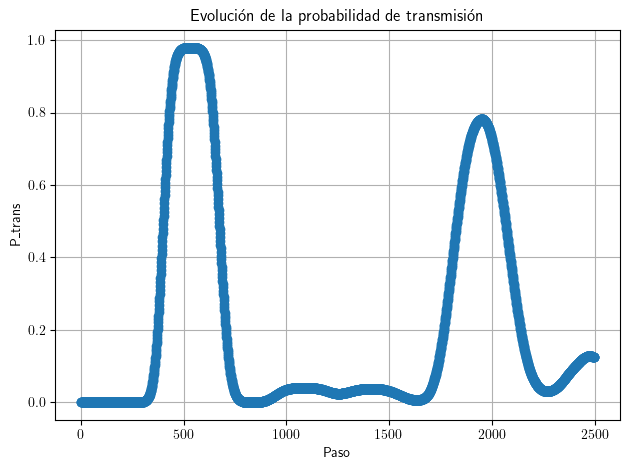

In [86]:
file_in  = "datos_PD.dat"
file_out = "grafica_PD.png"

# Leer usando coma como separador
datos = np.loadtxt(file_in)

x = datos[:,0]  # paso
pd = datos[:,1] # probabilidad de transmisión

plt.figure()
plt.plot(x, pd, '-o')
plt.xlabel('Paso')
plt.ylabel('P_trans')
plt.title('Evolución de la probabilidad de transmisión')
plt.grid(True)
plt.tight_layout()
plt.savefig(file_out)
plt.show()

#### Celda 13

Representación de los valores esperados de los observables.

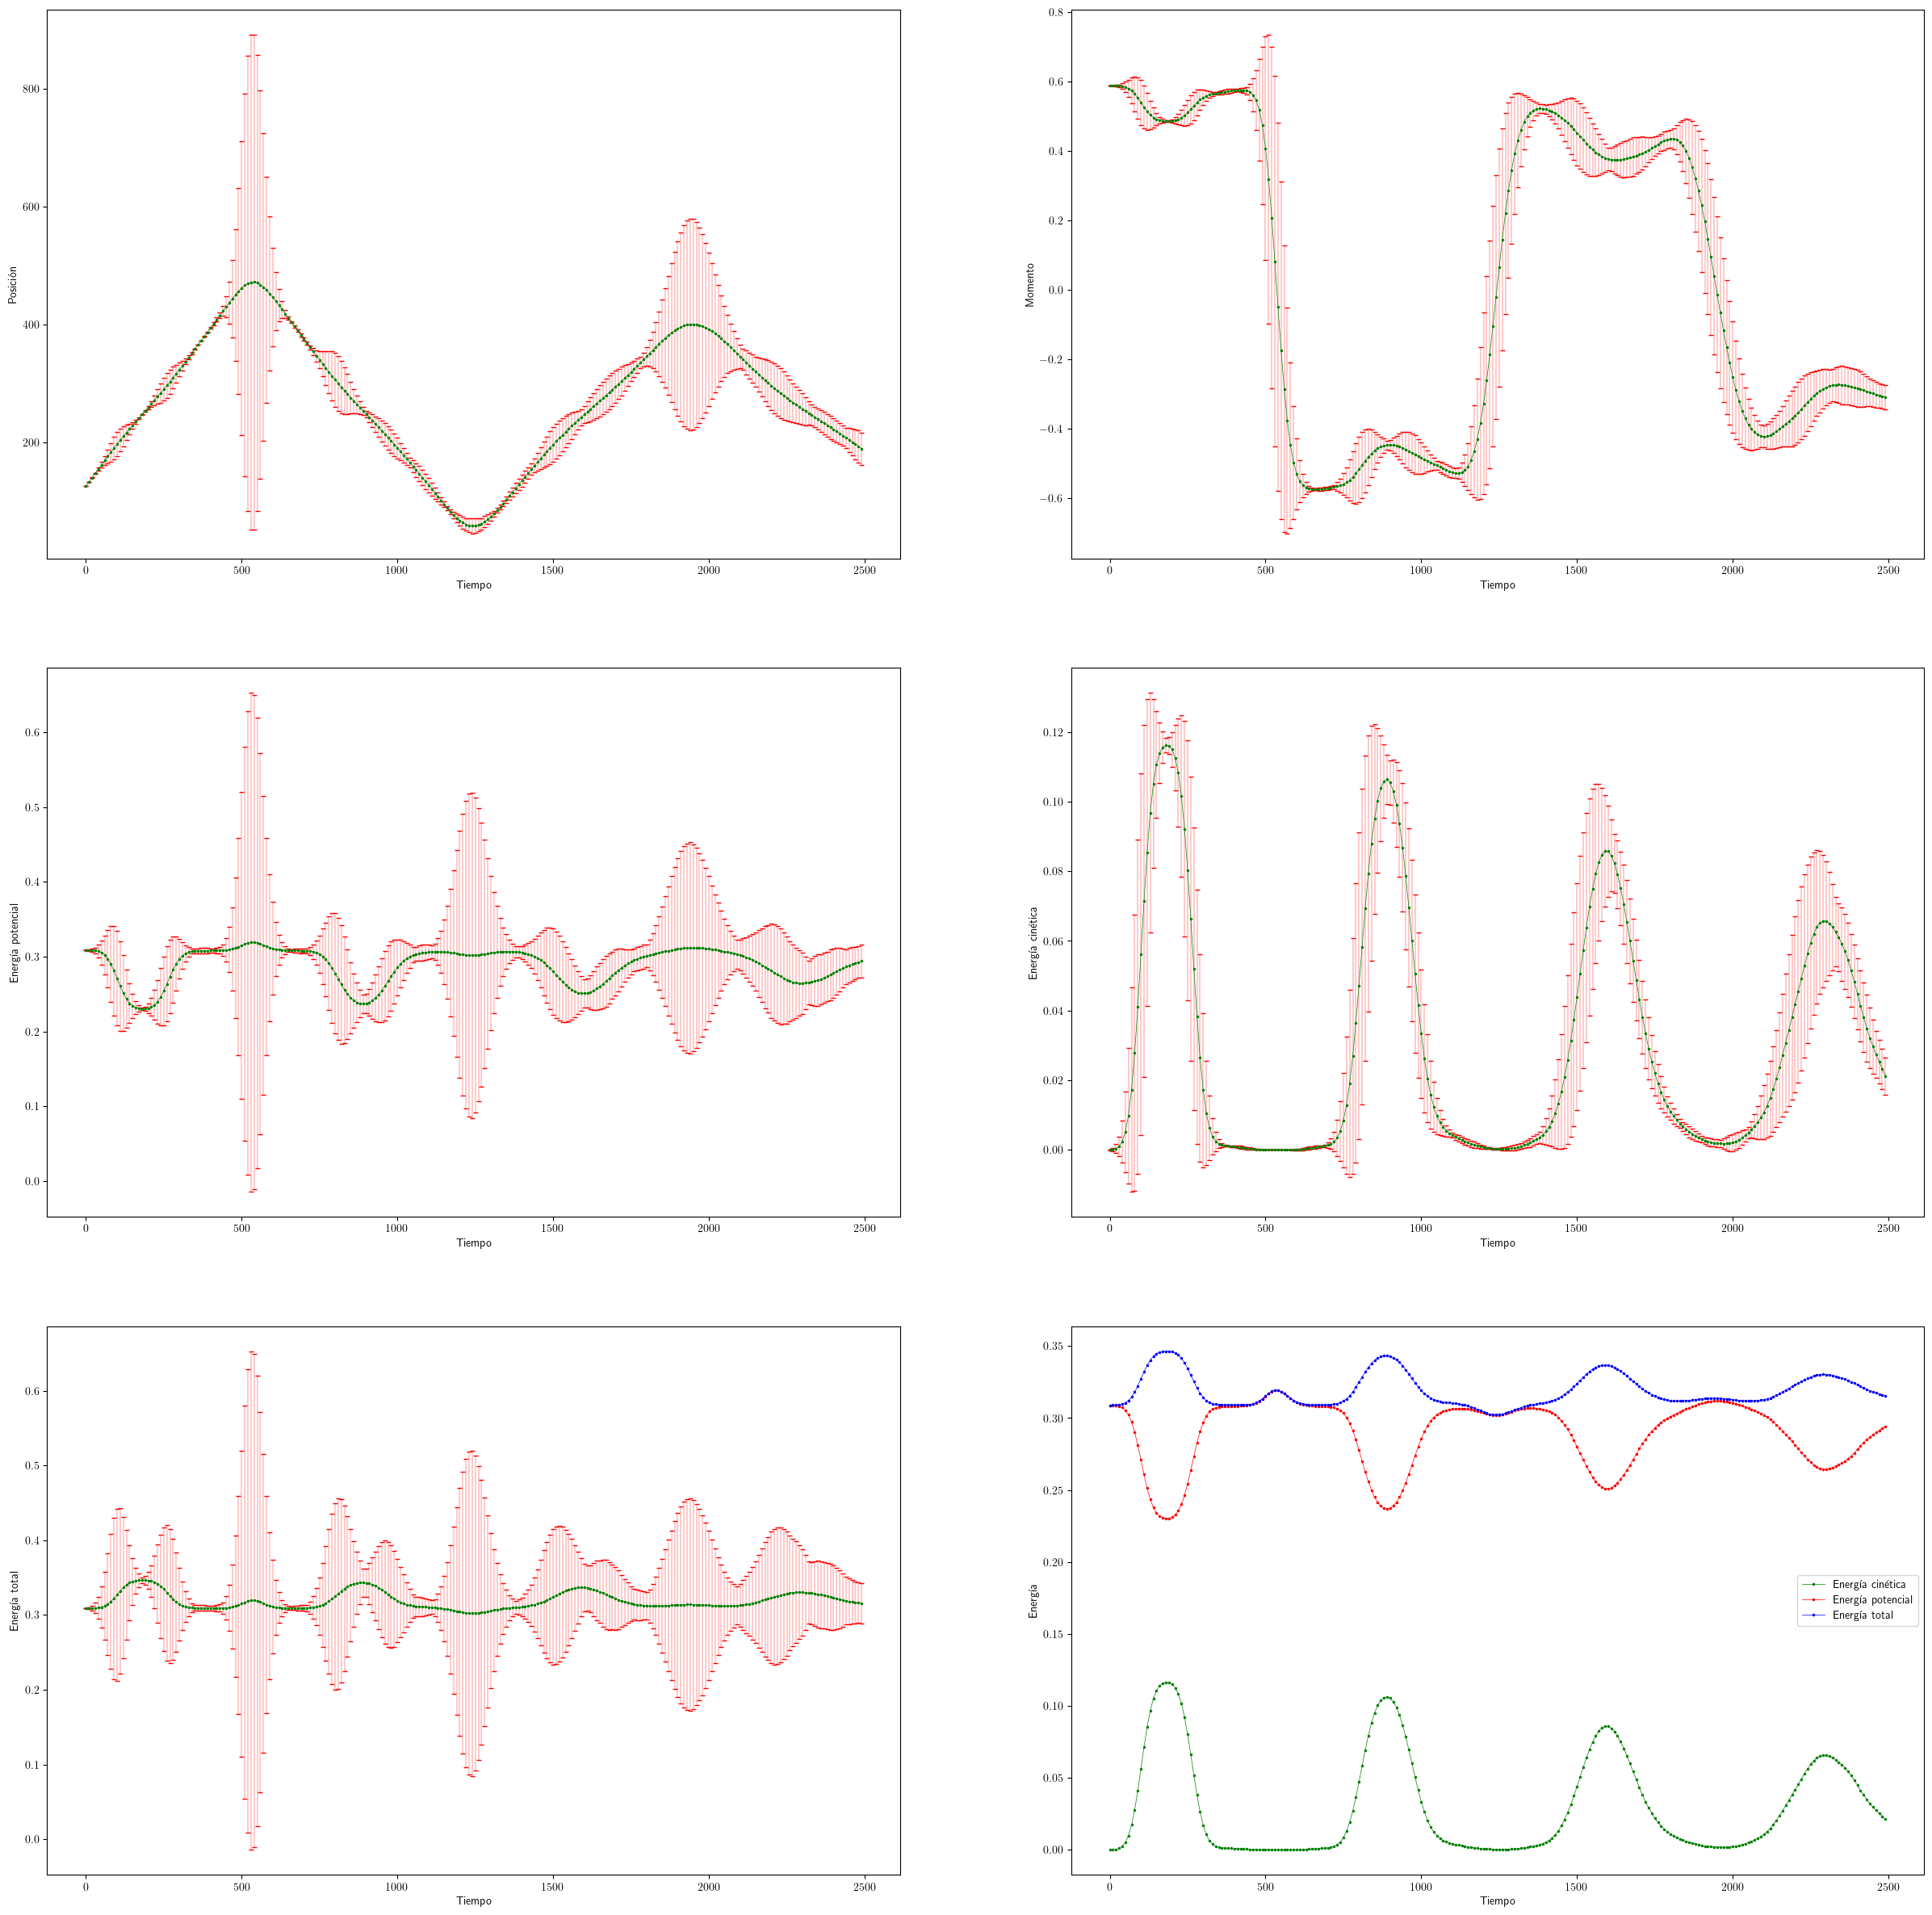

In [87]:
file_in = "datos_observables.dat"
file_out = "grafica_obsevables.png"

datos=np.loadtxt(file_in)

fig=plt.figure(figsize=[30,30])

ax1=fig.add_subplot(321)
ax1.errorbar(datos[:,0],datos[:,1], yerr=datos[:,2], color="green", ecolor="red", fmt="o-", capsize=2, markersize=1.5, linewidth=0.5, elinewidth=0.3)
ax1.set_xlabel("Tiempo")
ax1.set_ylabel("Posición")

ax2=fig.add_subplot(322)
ax2.errorbar(datos[:,0],datos[:,3],yerr=datos[:,4], color="green", ecolor="red", fmt="o-", capsize=2, markersize=1.5, linewidth=0.5, elinewidth=0.3)
ax2.set_xlabel("Tiempo")
ax2.set_ylabel("Momento")

ax3=fig.add_subplot(323)
ax3.errorbar(datos[:,0],datos[:,5],yerr=datos[:,6], color="green", ecolor="red", fmt="o-", capsize=2, markersize=1.5, linewidth=0.5, elinewidth=0.3)
ax3.set_xlabel("Tiempo")
ax3.set_ylabel("Energía potencial")

ax4=fig.add_subplot(324)
ax4.errorbar(datos[:,0],datos[:,7], yerr=datos[:,8], color="green", ecolor="red", fmt="o-", capsize=2, markersize=1.5, linewidth=0.5, elinewidth=0.3)
ax4.set_xlabel("Tiempo")
ax4.set_ylabel("Energía cinética")

ax5=fig.add_subplot(325)
ax5.errorbar(datos[:,0],datos[:,9], yerr=datos[:,10], color="green", ecolor="red", fmt="o-", capsize=2, markersize=1.5, linewidth=0.5, elinewidth=0.3)
ax5.set_xlabel("Tiempo")
ax5.set_ylabel("Energía total")

ax6=fig.add_subplot(326)
ax6.errorbar(datos[:,0],datos[:,7], color="green", fmt="o-", capsize=2, markersize=1.5, linewidth=0.5, label="Energía cinética")
ax6.errorbar(datos[:,0],datos[:,5], color="red", fmt="o-", capsize=2, markersize=1.5, linewidth=0.5, label="Energía potencial")
ax6.errorbar(datos[:,0],datos[:,9], color="blue", fmt="o-", capsize=2, markersize=1.5, linewidth=0.5, label="Energía total")
ax6.set_xlabel("Tiempo")
ax6.set_ylabel("Energía")
ax6.legend()

fig.savefig(file_out)

#### Celda 13

Representación de los valores de K en función de .

In [ ]:
plt.rcParams['text.usetex'] = True
plt.rcParams['text.latex.preamble'] = r'\usepackage{amsmath}'

file_in = "dependencias.dat"
file_out = "grafica_dependencias"

datos=np.genfromtxt(file_in, missing_values='-')

fig=plt.figure(figsize=[30,20])

landa=0.5
n_ciclos=100


ax1=fig.add_subplot(221)
ax1.errorbar(datos[:,0],datos[:,1], yerr=datos[:,2], color="green", ecolor="red", fmt="o-", capsize=2, markersize=1.5, linewidth=0.5, elinewidth=0.3, label="Valor simulado")
x_values = range(500, 2001, 500)

y_values = [4*(1-landa)/(4*(1-landa)+landa*landa*(np.sin(2*np.pi*n_ciclos*np.sqrt(1-landa)/5))**2) for x in x_values]

plt.plot(x_values, y_values, color="blue", linewidth=0.5, label="Valor teórico")
ax1.plot(datos[:0], 4*(1-landa)/(4*(1-landa)+landa*landa*(np.sin(2*np.pi*n_ciclos*np.sqrt(1-landa)/5))**2))
ax1.set_xlabel("N")
ax1.set_ylabel("Coeficiente de transmisión")
ax1.legend(loc="upper left")

ax2=fig.add_subplot(222)
ax2.errorbar(datos[:,3],datos[:,4], yerr=datos[:,5], color="green", ecolor="red", fmt="o-", capsize=2, markersize=1.5, linewidth=0.5, elinewidth=0.3, label="Valor simulado")
x_values = np.arange(0.1, 1, 0.001)
y_values = [4*(1-x)/(4*(1-x)+x*x*(np.sin(2*np.pi*n_ciclos*np.sqrt(1-x)/5))**2) for x in x_values]
plt.plot(x_values, y_values, color="blue", linewidth=0.5, label="Valor teórico")
ax2.set_xlabel(r'$\lambda$')
ax2.set_ylabel("Coeficiente de transmisión")
ax2.legend(loc="lower left")

fig.savefig(file_out)


## Resultados

En primer lugar, conseguimos estimar un valor para $K = 0.9840 \pm 0.1255$, el cual es muy próximo al valor de la probabilidad de transmisión en el máximo local, $PD(n_D) = 0.9793$. Esto se debe a que en el instante $n_D$, la mayor parte de la onda se transmite a la derecha, por lo que la probabilidad de encontrar la partícula es máxima. Al repetir las mediciones, la frecuencias muestral, $K$, se acerca cada vez más a la probabilidad. Por otro lado, notamos como parte de la onda se refleja, sino deberíamos obtener como valor $K = 1$.

Para estudiar las distintas dependencias, se fueron registrando en cada caso los valores de K en función de N y V(x) en el archivo "dependencias.dat", y se representaron usando la celda 13:

#### K-N

<img src='grafica_K_N.png' width="800" >

En este primer caso vemos como el valor de $K$ se mantiene constante independientemente del valor que pueda tomar $N$, conservando la probabilidad de transición sin verse afectado por el aumento de tamaño del sistema.

#### K-V

<img src='grafica_K_V.png'>

Para este caso, observamos que el valor de $K$ disminuye a medida que aumenta $\lambda$. Esto era esperable, puesto que al crecer $\lambda$ el potencial es mayor, acercándose cada vez más a una barrera de potencial infinito, por la que la onda no puede transmitirse.



### Valores esperados


#### Posición

En la gráfica correspondiente al valor esperado de la posición, y en el resto de magnitudes, destacamos tres instántes $t ~ 500, 1300, 2000$. En el caso de la posición, la tendencia de la curva verde nos indica en que dirección se está propagando la onda. A medida que esta aumenta, la onda se desplaza a la derecha, y si esta disminuye, hacia la izquierda. Aun así también se consiguen apreciar deformidades en la curva correspondientes a las partes de la onda que han sido reflejadas en algún punto, y no oscilan en la misma dirección que la onda transmitida.

#### Momento

Con el momento podemos hacer un análsis similar sobre estos tres instantes, pero en este caso estaríamos observando el sentido de la velocidad, y como este cambia a medida que la onda rebota en las paredes de potencial infinito.


#### Energía total

Revisando las gráficas correspondientes a las energías, comprobamos por una lado el intercambio constante entre energía cinética y potencial al impactar la onda con la barrera, dando lugar a una energía total aproximadamente constante, con pequeñas fluctuaciones. Esto se debe al modelo empleado, cuyo objetivo era mantener la energía como operador hermítico. Como parte del paquete se dispersa/refleja, cada pulso sucesivo de 
T y V es algo más pequeño, lo cual explica por qué las crestas de los picos van disminuyendo gradualmente.




